## Slide Tag (not Slide-seq) results notebook
<br>
<b>Description</b> : This notebook demonstrates the application of our interaction model to Slide-Tags data and show how the interaction genes are up-regulated in adjacent  vs. non-adjacent cells.<br>
<b>Author</b> : Alma Andersson (andera29@gene.com)<br>
<b>Date</b> : 08/21/2024

Import necessary packages

In [1]:
import telegraph as tg
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.stats import hypergeom

import pandas as pd
import numpy as np
import copy
import tqdm
import anndata as ad
from scipy.spatial import cKDTree
import os.path as osp

from scipy.stats import mannwhitneyu as Utest
import seaborn as sns

### Background

Slide-tags is an interesting spatial technique that gives you single-cell spatial resolution and full transcriptome readout. It was published [here](https://www.nature.com/articles/s41586-023-06837-4). We can use this to validate our interaction model, we can "visify" a portion of the cells and use the others as scRNA-seq data (with unknown) coordinates.

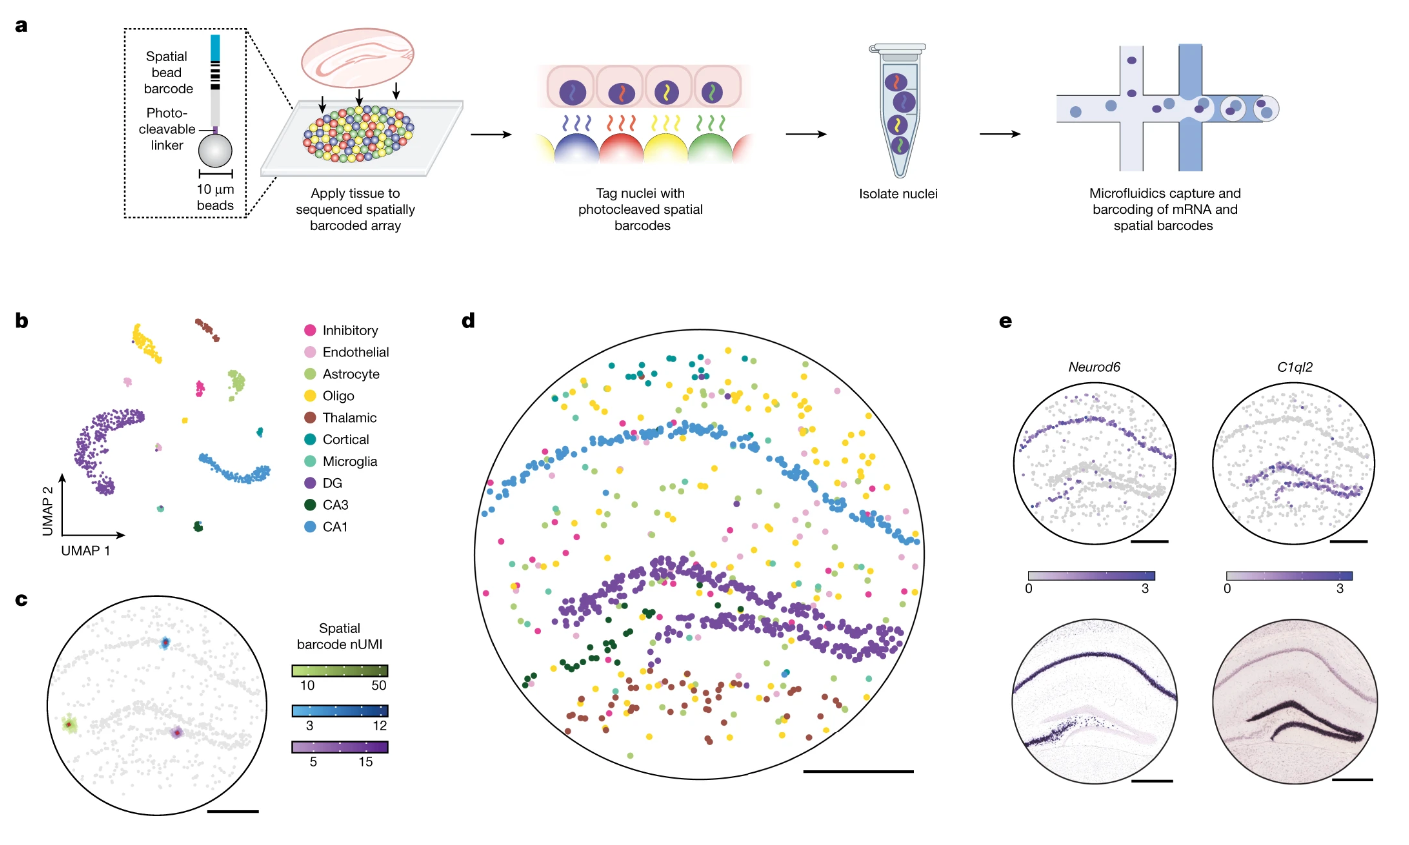

## Define Helper Functions

In [2]:
def pp_adata(ad_sc,ad_sp = None):
    drop = ad_sc.var_names.str.startswith(("MT-","MT","RP","RPS","LINC"))
    ad_sc = ad_sc[:,~drop].copy()
    drop = ad_sc.var_names.str.endswith((".1"))
    ad_sc = ad_sc[:,~drop].copy()

    sc.pp.filter_cells(ad_sc,min_counts=300)
    
    sc.pp.filter_genes(ad_sc,min_counts=10)

    if ad_sp is not None:
        sc.pp.filter_cells(ad_sp,min_counts=100)
        sc.pp.filter_genes(ad_sp,min_counts=10)
  

    ad_sc.layers['raw'] = ad_sc.X.copy()
    sc.pp.normalize_total(ad_sc,1e4)
    sc.pp.log1p(ad_sc)
    sc.pp.highly_variable_genes(ad_sc,n_top_genes=5000)
    ad_sc.layers['norm'] = ad_sc.X.copy()
    ad_sc.X = ad_sc.layers['raw'].copy()

    if ad_sp is not None:
        return ad_sc,ad_sp
    return ad_sc
    

Load Slide-tags data

In [3]:
DATA_PATH = '../../data/imod/slidetag_tonsil/tonsil.h5ad'

In [ ]:
with open('OUTPUT_DIR.txt','r+') as f:
    OUTPUT_ROOT = f.readlines()[0]

OUTPUT_DIR = osp.join(OUTPUT_ROOT, 'slidetags')
os.makedirs(OUTPUT_DIR, exist_ok = True)

In [4]:
ad_sc = ad.read_h5ad(DATA_PATH)

Define column that describes cell type

In [5]:
label_col = 'cell_type'

Add more broad annotations

In [6]:
ct_map = dict(B_germinal_center = 'Bcell',
                B_naive = 'Bcell',
                T_CD4 = 'Tcell',
                B_memory = 'Bcell',
                T_follicular_helper = 'Tcell',
                plasma = 'Plasma',
                FDC = 'FDC',
                T_CD8 = 'Tcell',
                NK = 'NK',
                mDC = 'DC',
                myeloid = 'Myeloid',
                pDC = 'DC',
                T_double_neg = 'Tcell',
             )

ad_sc.obs['cell_type_broad'] = ad_sc.obs[label_col].map(ct_map)

## Visify the Slide-tag data

By (circular) binning of the cells in 2D space, we will create Visium-like data. We will later use this as our spatial reference, while we use the single-cell observations as non-spatial data to be mapped.

Create a grid over the spatial domain

In [7]:
crd = ad_sc.obsm['spatial']
xx = np.linspace(crd[:,0].min(), crd[:,0].max(), 25)
yy = np.linspace(crd[:,1].min(), crd[:,1].max(), 25)
xx,yy = np.meshgrid(xx,yy)
xx = xx.flatten()
yy = yy.flatten()
crd_sp = np.hstack((xx[:,None],yy[:,None]))

Overlay original data on grid, each dot represents a spot in the Visium data

(211.6688046666661, 3379.540054380956, 288.73521504980397, 3466.579692287455)

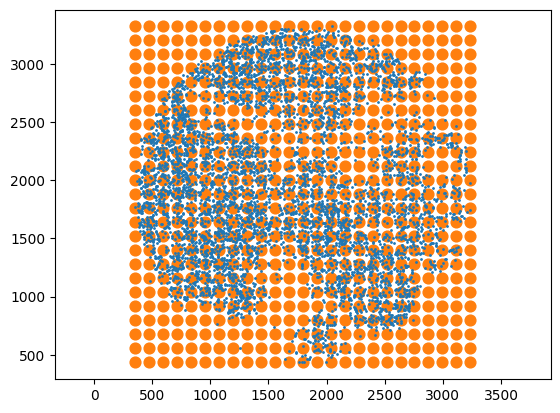

In [8]:
plt.scatter(ad_sc.obsm['spatial'][:,0],ad_sc.obsm['spatial'][:,1], s =1 )

plt.scatter(crd_sp[:,0],crd_sp[:,1], s =60, zorder = -1)

plt.axis('equal') 

Compute distance to nearest spot for every cell

In [9]:
kd = cKDTree(crd_sp)
dists,idxs = kd.query(crd, k = 1 )

Visualize which cells that would remain if a given threshold value on the distance is used

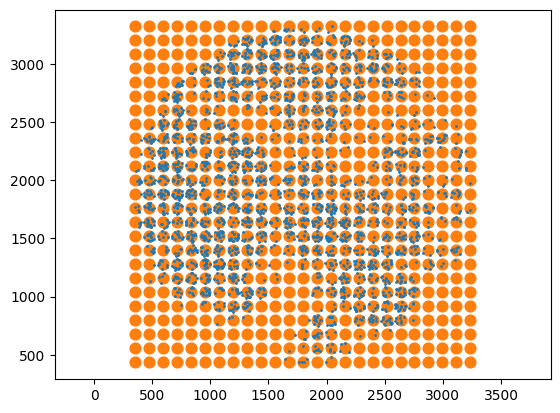

In [10]:
thrs = 50
keep = dists < thrs

plt.scatter(ad_sc.obsm['spatial'][keep,0],ad_sc.obsm['spatial'][keep,1], s =1 )

plt.scatter(crd_sp[:,0],crd_sp[:,1], s =60, zorder = -1 )

plt.axis('equal') 
plt.show()

Only keep the thresholded cells

In [11]:
ad_sc = ad_sc[keep].copy()
idxs = idxs[keep]

Register which spot each cell belongs to

In [12]:
ad_sc.obs['sp_map'] = idxs

Create a mapping matrix (T)

In [13]:
T = np.zeros((len(ad_sc), len(crd_sp)))
T[np.arange(len(ad_sc)),idxs] = 1

Create gene expression for visified data

In [14]:
X_new = np.dot(ad_sc.X.T,T).T

Create anndata object for visified data

In [15]:
ad_vs = ad.AnnData(X_new,
                   var = ad_sc.var,
                  )
ad_vs.obsm['spatial'] = crd_sp

In [19]:
ad_sc.write_h5ad(osp.join(OUTPUT_DIR, 'sc.h5ad'))
ad_vs.write_h5ad(osp.join(OUTPUT_DIR, 'vs.h5ad'))

Register original spot it

In [16]:
ad_vs.obs['sp_og'] = np.arange(len(ad_vs))

Visualize Visified data gene expression (of a random genes)

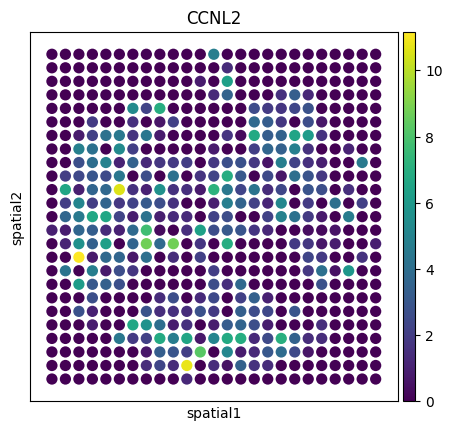

In [17]:
sc.pl.spatial(ad_vs, color=['CCNL2'], spot_size=100)

## Process data and run workflow

We will map the original Slide-tag scRNA-seq data to the Visified data.

Specify cell type column to use

In [18]:
label_col = 'cell_type'

In [23]:
np.random.seed(42)

Preprocess data

In [24]:
ad_sc,ad_vs = pp_adata(ad_sc,ad_vs)

Initialize state dict

In [25]:
hvg_genes = ad_sc.var_names[ad_sc.var.highly_variable.values].tolist()

input_dict_1 = tg.met.utils.adatas_to_input({'from':ad_sc.copy(),
                                             'to':ad_vs.copy()}, # provide the data to be used
                                             categorical_labels={'from':[label_col]}, # include cluster labels in the design matrix
                                            )

Run mapping method

In [26]:
tg.met.pp.StandardTangramV2.run(input_dict_1)

map_res_1 = tg.met.map_methods.TangramV2Map.run(input_dict_1,
                                                num_epochs = 1000,
                                                genes =hvg_genes,
                                                mode = 'hejin_workflow',
                                             )

input_dict_1.update(map_res_1)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5000 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.802, KL reg: 2.876, Entropy reg: -8.119
Score: 0.844, KL reg: 2.565, Entropy reg: -6.901
Score: 0.847, KL reg: 2.565, Entropy reg: -6.757
Score: 0.848, KL reg: 2.565, Entropy reg: -6.708
Score: 0.848, KL reg: 2.565, Entropy reg: -6.679
Score: 0.848, KL reg: 2.565, Entropy reg: -6.662
Score: 0.849, KL reg: 2.565, Entropy reg: -6.649
Score: 0.849, KL reg: 2.565, Entropy reg: -6.639
Score: 0.849, KL reg: 2.565, Entropy reg: -6.632


INFO:root:Renormalizing Single cell data


Score: 0.849, KL reg: 2.565, Entropy reg: -6.629


INFO:root:Begin training with 5000 genes and rna_count_based density_prior in cells mode after renormalization
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.821, KL reg: 0.261, Entropy reg: -17345.797
Score: 0.992, KL reg: 0.001, Entropy reg: -1792.733
Score: 0.995, KL reg: 0.000, Entropy reg: -1067.030
Score: 0.995, KL reg: 0.000, Entropy reg: -927.836
Score: 0.995, KL reg: 0.000, Entropy reg: -873.631
Score: 0.995, KL reg: 0.000, Entropy reg: -844.777
Score: 0.995, KL reg: 0.000, Entropy reg: -829.013
Score: 0.995, KL reg: 0.000, Entropy reg: -818.399
Score: 0.995, KL reg: 0.000, Entropy reg: -811.422
Score: 0.995, KL reg: 0.000, Entropy reg: -807.295


INFO:root:Saving results..


Run interaction model

In [27]:
tg.met.pp.StandardScanpy.run(input_dict_1,target_objs = ['X_from'])

inter_res = tg.dev.imod.methods.InteractionModel.run(input_dict_1,
                                                     n_epochs = 1000,
                                                     learning_rate = 0.01)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 92.0 K | n/a 
---------------------------------------------
92.0 K    Trainable params
0         Non-trainable params
92.0 K    Total params
0.368     Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [30]:
inter_res.to_netcdf(osp.join(OUTPUT_DIR,'inter_res.netcdf'))

## Downstream analysis

In [19]:
import xarray as xr

In [20]:
inter_res = xr.load_dataset(osp.join(OUTPUT_DIR,'inter_res.netcdf'))

Get model coefficients

In [21]:
# cell type x cell type interaction coefficients
beta = inter_res['beta'].to_dataframe().unstack()['beta'].copy()
# cell type coefficients
alpha = inter_res['alpha'].to_dataframe().unstack()['alpha'].copy()
# baseline coefficients
gamma = inter_res['gamma'].to_dataframe()['gamma'].copy()

In [22]:
beta = beta.reset_index()
beta.index = beta['labels'].astype(str) + '_vs_' + beta['labels_'].astype(str)
beta.drop(labels = ['labels','labels_',],inplace = True,axis =1)


Process data (standard normalization)

In [23]:
sc.pp.normalize_total(ad_sc)
sc.pp.log1p(ad_sc)

## Validation

In the cell below can assess whether the gene expression of the top predicted genes are actually higher expressed in genes that are adjacent to its sender cell type or not.

In [24]:
from scipy.stats import binom

In [29]:
# dictionaries for storing results

# set number of top genes to look at
n_top = 10

df_dict = dict(values = [], adj_nadj = [], interaction = [])
cn_dict = dict(n_hi = 0, n_lo = 0)
delta_dict = dict()

# iterate over interactions
for inter in beta.index:

    # get name of sender and receiver cell type
    rec_type, sig_type = inter.split('_vs_')

    # geta beta values
    beta_vals = beta.loc[inter]

    # get top beta gene names
    top_beta =  beta_vals.sort_values(ascending = False).head(n_top).index.tolist()
    top_beta = [x.upper() for x in top_beta]
    top_beta = [x for x in top_beta if x in ad_sc.var_names]

    # skip if mismatch
    if len(top_beta) < 1:
        continue

    # only look at cross-celltype interactions
    if rec_type == sig_type:
        continue

    # get index of receiver cell type
    is_rec = np.where(ad_sc.obs[label_col].values == rec_type)[0]
    # get index of signaler cell type
    is_sig = np.where(ad_sc.obs[label_col].values == sig_type)[0]

    # get spatial coordinates
    crd = ad_sc.obsm['spatial']

    # create KDTree for signaling cells
    kd_sig = cKDTree(crd[is_sig])

    # compute distance for each receiver cell to its nearest signaler cell
    dists,_ = kd_sig.query(crd[is_rec], k = 1)

    # get top and bottom quantile values
    q_low = np.quantile(dists,0.25)
    q_hi = np.quantile(dists,0.75)

    # get receiver cell type cells that are close to signaler cells (using GT spatial coordinates)
    rec_adj = is_rec[np.where(dists <= q_low)[0]]
    # get receiver cell type cells that are far from signaler cells (using GT spatial coordinates)
    rec_nadj = is_rec[np.where(dists >= q_hi)[0]]

    # get mean (across genes) gene expression of proximal receivers
    x_adj_mat = np.array(ad_sc[rec_adj,top_beta].X)
    x_adj = x_adj_mat.mean(axis=1)
    # get mean (across genes) gene expression of distal receivers
    x_nadj_mat = np.array(ad_sc[rec_nadj, top_beta].X)
    x_nadj = x_nadj_mat.mean(axis=1)

    # count number of correct directions
    for ii in range(len(top_beta)):
        
        x_adj_mean = x_adj_mat[:,ii].mean()
        x_nadj_mean = x_nadj_mat[:,ii].mean()

        delta_dict[inter] = x_adj_mean - x_nadj_mean
        
        if x_adj_mean > x_nadj_mean:
            cn_dict['n_hi'] += 1
        else:
            cn_dict['n_lo'] += 1
        

    # update results dict
    df_dict['values'] +=  np.hstack((x_adj,x_nadj)).tolist()
    df_dict['adj_nadj'] += ['adj'] * len(x_adj) + ['nadj'] * len(x_nadj)
    df_dict['interaction'] += [inter] * ( len(x_adj) + len(x_nadj))

df = pd.DataFrame( df_dict)

Update category order of the results

In [30]:
n_success = cn_dict['n_hi']
n_total = n_success + cn_dict['n_lo']

pval = binom.sf(n_success, n_total, p = 0.5)

print(f"For {cn_dict['n_hi']}/{cn_dict['n_hi'] + cn_dict['n_lo']} genes the mean expression in adj was higher, this is an accuracy of {100 * (cn_dict['n_hi']/ ( cn_dict['n_hi'] + cn_dict['n_lo'])):0.2f}% | pvalue = {pval:e}")

For 1271/1560 genes the mean expression in adj was higher, this is an accuracy of 81.47% | pvalue = 9.584613e-148


Save delta object capturing gene-wise difference

In [211]:
delta_df = pd.Series(delta_dict)
delta_df.to_csv(osp.join(OUTPIT_DIR,'delta_df.csv'))